# CONLL Entity Relation Extraction Tutorial
This tutorial is to show you how to make a very simple, yet thorough learning program that also utilizes the domain knowledge to apply constraints on Entity Recognition and Relation Extraction

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
root = os.path.dirname(currentdir)
# print("root Folder Absoloute path: ", root)

import sys
sys.path.append(root)

import logging

logging.basicConfig(level=logging.INFO)

from IPython.display import Image

### Task
The task is to detect entities and relationships from a sentence and classify them correctly. Following is an example of this:

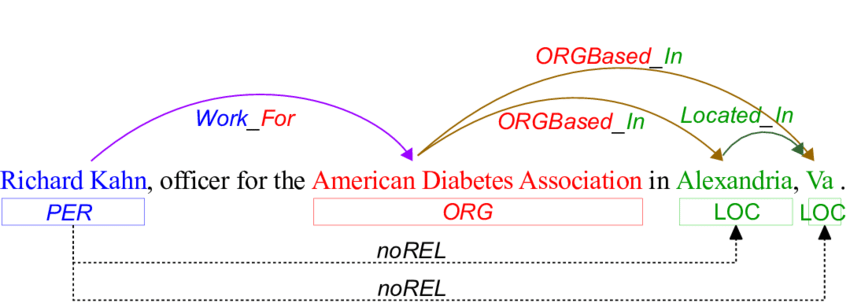

In [2]:
Image(filename='emr_example.png') 

## The Graph
First we define the graph code that defines the domain knowledge for this problem.
This graph defines a set of input side data structure in the subgraph of *linguistics* and define the output decision space in the subgraph of *application*. We encourage you to follow the same split for more readable graph declaration but the structure is optional.

In [3]:
from regr.graph import Graph, Concept, Relation
from regr.graph.logicalConstrain import ifL, andL, nandL, V, orL


Graph.clear()
Concept.clear()
Relation.clear()

with Graph('global') as graph:
    with Graph('linguistic') as ling_graph:       
        word = Concept(name='word')
        phrase = Concept(name='phrase')
        sentence = Concept(name='sentence')
        (rel_sentence_contains_word,) = sentence.contains(word)
        (rel_sentence_contains_phrase,) = sentence.contains(phrase)
        (rel_phrase_contains_word,) = phrase.contains(word)

        pair = Concept(name='pair')
        (rel_pair_phrase1, rel_pair_phrase2) = pair.has_a(arg1=phrase, arg2=phrase)

Log file for dataNode is in: /home/hfaghihi/Framework/new/DomiKnowS/tutorials/datanode.log


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('arg1', 'phrase'), ('arg2', 'phrase')]) is used.


The graph structure can be used as a background knowledge to introduce rules into the inference algorithms automatically, you can specify the keyword *auto_constraint* to be **True** if you want to generate automatic constraints based on the graph. You can disable the constraint generation for specific relationship definition by setting the same parameter as **False**

In [4]:
with graph:
    with Graph('application', auto_constraint=True) as app_graph:
        entity = phrase(name='entity')
        people = entity(name='people', auto_constraint=True)
        organization = entity(name='organization', auto_constraint=False)
        location = entity(name='location', auto_constraint=None)
        # auto_constraint->True due to its graph
        other = entity(name='other')
        o = entity(name='O')

        work_for = pair(name='work_for')
        
        located_in = pair(name='located_in')
        

        live_in = pair(name='live_in')
        # auto_constraint->True due to its graph

        orgbase_on = pair(name='orgbase_on')
        kill = pair(name='kill')

The **has_a** relationship is equivalant to having a many to many relationships between the arguments in the relation. So the *pair*, we are introducing a relationship between phrases. The **contains** relationship also implies a parent child structure which is a one-to-many relationship between the concept that contains the other one and the concept being contained.

In [5]:
from regr.graph.relation import disjoint

with graph:
    with app_graph:    
        ifL(work_for, V(name='x'), andL(people, V(v=('x', rel_pair_phrase1.name)), organization, V(v=('x', rel_pair_phrase2.name))))
#         work_for.has_a(people, organization, auto_constraint=True)

#         ifL(located_in, V(name='x'), andL(location, V(v=('x', rel_pair_phrase1.name)), location, V(v=('x', rel_pair_phrase2.name))))
        located_in.has_a(location, location, auto_constraint=True)
        
#         ifL(live_in, V(name='x'), andL(people, V(v=('x', rel_pair_phrase1.name)), location, V(v=('x', rel_pair_phrase2.name))))
        live_in.has_a(people, location, auto_constraint=None)

        #ifL(orgbase_on, ('x', 'y'), andL(organization, ('x',), location, ('y',)))
        ifL(orgbase_on, V(name='x'), andL(organization, V(v=('x', rel_pair_phrase1.name)), location, V(v=('x', rel_pair_phrase2.name))))
        
        #ifL(kill, ('x', 'y'), andL(people, ('x',), people, ('y',)))
        ifL(kill, V(name='x'), andL(people, V(v=('x', rel_pair_phrase1.name)), people, V(v=('x', rel_pair_phrase2.name))))
        
        disjoint(people, organization, location, other, o)
        orL(people, organization, location, other, o)

To introduce the domain range constraints for relationships, we can use either the **has_a** graph structure or directluy introduce a constraint by using our Constraint interface. Remember that if you use the **has_a** to introduce the rules for the domain and range of the arguments, you have to specify the auto_constraints to be *True*. If you put *auto_constraint=None* or do not add any *auto_constraint* input then the *auto_constraint* value will be inherited from the graph definition as all the nodes and relationships are defined inside the graph.

The **nandL** constraint is also implying that the concept classes mentioned in the paranthesis are disjoint.

For more information on how to write your own constraints, please refer to our constraint interface tutorials and documents!

### Visualize
We can use the following code to visualize the graph representations.

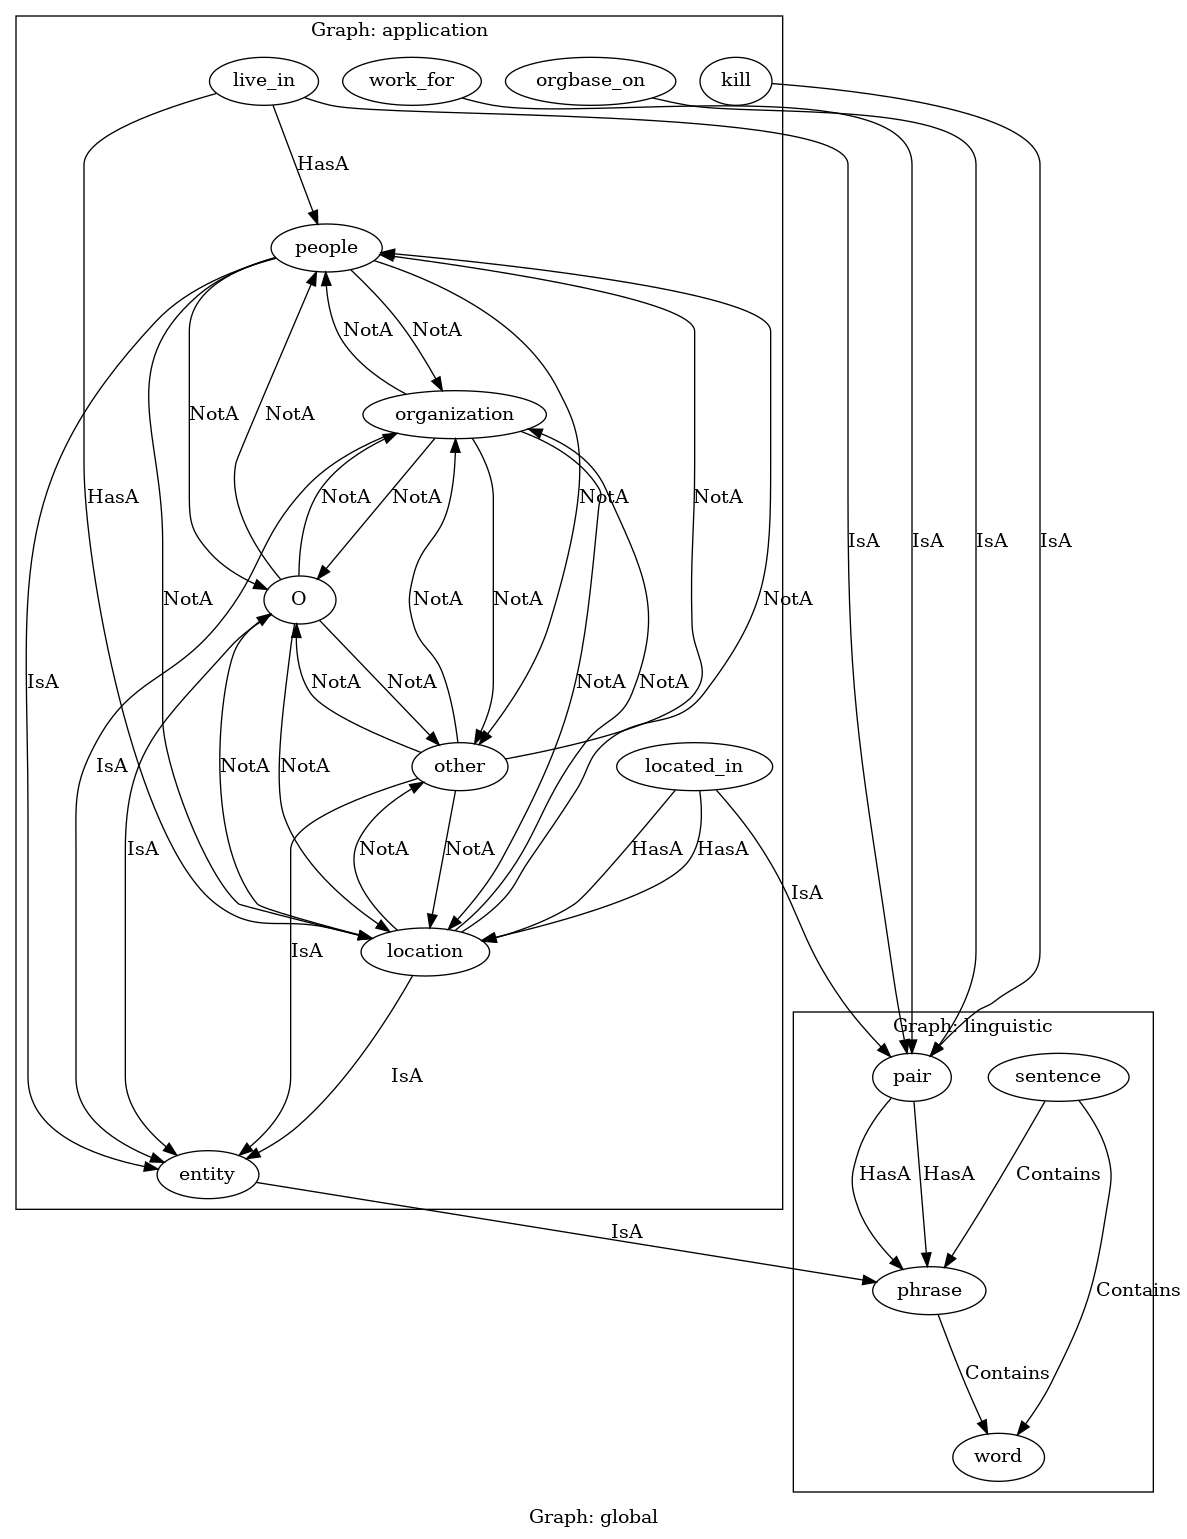

In [6]:
graph.visualize("./image")
Image(filename='image.png') 

## Data and Data Reader
Here we use the Pytorch DataLoader to define our training and test instances. You can use your customized readers as long as the output for the reader class is an iterable object

In [7]:
from torch.utils.data import DataLoader

from examples.conll04.conll.data.reader import Conll04CorpusReader

class Conll04DataLoader(DataLoader):
    def __init__(self, path, reader=None, **kwargs):
        self.path = path
        self.reader = reader or Conll04CorpusReader()
        sentences_list, relations_list = self.reader(path)
        samples = list(zip(sentences_list, relations_list))
        super().__init__(samples, collate_fn=self._collate_fn, **kwargs)
    
    def _collate_fn(self, batch):
        sentences, relations = zip(*batch)
        # (tokens, pos, label)
        # (relation_type, (src_index, src_token), (dst_index, dst_token))
        tokens, postags, labels = zip(*sentences)
        data_item = {
            'sentence': [' '.join(token_list) for token_list in tokens],
            'tokens': list(tokens),
            'postag': list(postags),
            'label': list(labels),
            'relation': list(relations),
        }
        #import pdb; pdb.set_trace()
        return data_item

class SingletonDataLoader(Conll04DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, batch_size=1, **kwargs)

    def _collate_fn(self, batch):
        assert len(batch) == 1
        sentences, relations = zip(*batch)
        # (tokens, pos, label)
        # (relation_type, (src_index, src_token), (dst_index, dst_token))
        tokens, postags, labels = zip(*sentences)
        data_item = {
            #'sentence': [' '.join(token_list) for token_list in tokens],
            'tokens': tokens[0],
            'postag': postags[0],
            'label': labels[0],
            'relation': relations[0],
        }
        return data_item

Let's see how the output of the reader looks like

In [8]:
train_reader = SingletonDataLoader('../examples/conll04/data/conll04.corp_1_train.corp')
test_reader = SingletonDataLoader('../examples/conll04/data/conll04.corp_1_test.corp')

Reading Corpus: 100%|██████████| 28028/28028 [00:00<00:00, 234944.40it/s]


In [9]:
print(list(iter(train_reader))[120])

{'tokens': ['Officials', 'COMMA', 'Newspapers', 'Greet', 'End', 'of', 'SRV', 'Embargo', 'Editorial', 'Hails', 'Embargo', 'End', 'BK0502093694', 'Bangkok', 'THE/NATION', 'in', 'English', '5/Feb/94', 'p', 'A6'], 'postag': ['NNS', ',', 'NNP', 'NNP', 'NN', 'IN', 'NNP', 'NNP', 'NN', 'NNP', 'NNP', 'NN', 'NNP', 'NNP', 'DT/NNP', 'IN', 'NNP', 'CD/NNP/CD', 'NN', 'NNP'], 'label': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Loc', 'Org', 'O', 'O', 'Other', 'O', 'O'], 'relation': [('OrgBased_In', (14, ('THE/NATION', 'DT/NNP', 'Org')), (13, ('Bangkok', 'NNP', 'Loc')))]}


We have defined the keywords to be `tokens`, `postag`, `label`, `relation`

## Model Declaration

In this section, we start by defining our sensors and required toolkits and then start connecting our sensors and learners to their right place in the graph.

First, As we want to use `Spacy` to define the word features, we intialize a `Spacy` instance.

In [10]:
import spacy
# from spacy.lang.en import English
nlp = spacy.load('en_core_web_sm') #English()

FEATURE_DIM = 96

We also define a classifier which we will use later in the process

In [11]:
import torch

class Classifier(torch.nn.Sequential):
    def __init__(self, in_features) -> None:
        linear = torch.nn.Linear(in_features, 2)
        super().__init__(linear)

Next we import a set of our predefined basic sensors which enables us to use the functionality of the DomiKnows declarative sensor and learner definition

In [12]:
from regr.sensor.pytorch.sensors import FunctionalSensor, JointSensor, ReaderSensor, FunctionalReaderSensor
from regr.sensor.pytorch.learners import ModuleLearner
from regr.sensor.pytorch.relation_sensors import CompositionCandidateSensor
from regr.sensor.pytorch.query_sensor import DataNodeReaderSensor

graph.detach()

Then we start by Definign some **ReaderSensor**s to connect our DataLoader with appropriate properties in the graph

In [13]:
phrase['text'] = ReaderSensor(keyword='tokens')
phrase['postag'] = ReaderSensor(keyword='postag')

After reading the data about the Phrases, we also read the annotation of labels into the graph by using a customized **ReaderSensor** which we call **FunctionalReaderSensor**. In addition to having access to the DataLoader output, the **FunctionalReaderSensor** accepts a function as input at initialization which it will apply on the read data before generating the outputs. Remember to put `label=True` Whenever you are reading an annotation to the graph.

In [14]:
def find_label(label_type):
        def find(data):
            try:
                label = torch.tensor([item==label_type for item in data])
            except:
                print(data)
                raise
            return label # torch.stack((~label, label), dim=1)
        return find
        raise
phrase[people] = FunctionalReaderSensor(keyword='label', forward=find_label('Peop'), label=True)
phrase[organization] = FunctionalReaderSensor(keyword='label', forward=find_label('Org'), label=True)
phrase[location] = FunctionalReaderSensor(keyword='label', forward=find_label('Loc'), label=True)
phrase[other] = FunctionalReaderSensor(keyword='label', forward=find_label('Other'), label=True)
phrase[o] = FunctionalReaderSensor(keyword='label', forward=find_label('O'), label=True)

Next, We define a word to vector sensor using a **FunctionalSensor** to generate the word representation from their string utilizing the spacy library

In [15]:
def word2vec(text):
    texts = list(map(lambda x: ' '.join(x.split('/')), text))
    tokens_list = list(nlp.pipe(texts))
    return torch.tensor([tokens.vector for tokens in tokens_list])

phrase['w2v'] = FunctionalSensor('text', forward=word2vec)

Now as our data included the phrases directly, we want to merge phrases in the same sentence to create the concept nodes for `sentence`. To generate a concept from another one, we have to use the edges defined on the graph between those two concepts. Here we use the `contains` edge defined on the graph and as the default relationship was defined from a sentence to a phrase, here we use the keyword `reversed` after the relationship variable to indicate the reverse direction of the same relationship. 

Whenever, you want to define the connection, you have to return a matric connecting the nodes from the source to the target concept in a form of 0 and 1s. Apart from that we also want to generate the feature `Text` containing the actual string feature for a sentence in the same sensor, because of that, we use a **JointSensor** which is able to connect one sensor to multiple proprties on the graph.

In [16]:
def merge_phrase(phrase_text):
    return [' '.join(phrase_text)], torch.ones((1, len(phrase_text)))
sentence['text', rel_sentence_contains_phrase.reversed] = JointSensor(phrase['text'], forward=merge_phrase)

Next, we define a set of learners on top of the phrases to decide about each phrase class. In this scenario, we are assigning independent boolean classifers for each phrase type.

In [17]:
phrase[people] = ModuleLearner('w2v', module=Classifier(FEATURE_DIM))
phrase[organization] = ModuleLearner('w2v', module=Classifier(FEATURE_DIM))
phrase[location] = ModuleLearner('w2v', module=Classifier(FEATURE_DIM))
phrase[other] = ModuleLearner('w2v', module=Classifier(FEATURE_DIM))
phrase[o] = ModuleLearner('w2v', module=Classifier(FEATURE_DIM))

Next, we define the pair concept and use the **ComposionCandidateSensor** to generate pair candidates based on our phrases. This sensor receives one instance of each argument at a time and return **True** to make a candidate pair for that combination or **False** to skip the combination.

In [18]:
pair[rel_pair_phrase1.reversed, rel_pair_phrase2.reversed] = CompositionCandidateSensor(
    phrase['w2v'],
    relations=(rel_pair_phrase1.reversed, rel_pair_phrase2.reversed),
    forward=lambda *_, **__: True)

Next, we define a property `emb` for the pair candidates based on the representation of their arguments. We use the relation links defined on the previous sensor to retrieve the `w2v` properties on each argument and concat them in the `forward` function of the **FunctionalSensor**.

In [19]:
pair['emb'] = FunctionalSensor(
    rel_pair_phrase1.reversed('w2v'), rel_pair_phrase2.reversed('w2v'),
    forward=lambda arg1, arg2: torch.cat((arg1, arg2), dim=-1))

Then, we define our classifiers on top of the pair `emb` properties to decide about the type of each pair

In [20]:
pair[work_for] = ModuleLearner('emb', module=Classifier(FEATURE_DIM*2))
pair[located_in] = ModuleLearner('emb', module=Classifier(FEATURE_DIM*2))
pair[live_in] = ModuleLearner('emb', module=Classifier(FEATURE_DIM*2))
pair[orgbase_on] = ModuleLearner('emb', module=Classifier(FEATURE_DIM*2))
pair[kill] = ModuleLearner('emb', module=Classifier(FEATURE_DIM*2))

Then, we read the annotation of each pair from the DataLoader

In [21]:
def find_relation(relation_type):
    def find(arg1m, arg2m, data):
        label = torch.zeros(arg1m.shape[0], dtype=torch.bool)
        for rel, (arg1,*_), (arg2,*_) in data:
            if rel == relation_type:
                i, = (arg1m[:, arg1] * arg2m[:, arg2]).nonzero(as_tuple=True)
                label[i] = True
        return label # torch.stack((~label, label), dim=1)
    return find
pair[work_for] = FunctionalReaderSensor(pair[rel_pair_phrase1.reversed], pair[rel_pair_phrase2.reversed], keyword='relation', forward=find_relation('Work_For'), label=True)
pair[located_in] = FunctionalReaderSensor(pair[rel_pair_phrase1.reversed], pair[rel_pair_phrase2.reversed], keyword='relation', forward=find_relation('Located_In'), label=True)
pair[live_in] = FunctionalReaderSensor(pair[rel_pair_phrase1.reversed], pair[rel_pair_phrase2.reversed], keyword='relation', forward=find_relation('Live_In'), label=True)
pair[orgbase_on] = FunctionalReaderSensor(pair[rel_pair_phrase1.reversed], pair[rel_pair_phrase2.reversed], keyword='relation', forward=find_relation('OrgBased_In'), label=True)
pair[kill] = FunctionalReaderSensor(pair[rel_pair_phrase1.reversed], pair[rel_pair_phrase2.reversed], keyword='relation', forward=find_relation('Kill'), label=True)

After connecting all the sensors and learners to the graph, we have to define a Program instance to be able to autoamtically train and test our models. Here, we use the **POIProgram**, which execute all the properties which have multiple assignment in the graph~(multiple sensors connect) and their dependencies.

In [24]:
from regr.program import POIProgram, IMLProgram, SolverPOIProgram
from regr.program.primaldualprogram import PrimalDualProgram
from regr.program.model.pytorch import SolverModel
from regr.program.metric import MacroAverageTracker, PRF1Tracker, PRF1Tracker, DatanodeCMMetric
from regr.program.loss import NBCrossEntropyLoss, NBCrossEntropyIMLoss

#ILP inference
program = SolverPOIProgram(graph, poi=(sentence, phrase), inferTypes=['ILP', 'softmax'], loss=MacroAverageTracker(NBCrossEntropyLoss()), metric={'ILP':PRF1Tracker(DatanodeCMMetric()),'softmax':PRF1Tracker(DatanodeCMMetric('softmax'))})

#IML inference and training 
program = IMLProgram(graph, poi=(sentence, phrase), inferTypes=['ILP', 'softmax'], loss=MacroAverageTracker(NBCrossEntropyLoss()), metric={'ILP':PRF1Tracker(DatanodeCMMetric()),'softmax':PRF1Tracker(DatanodeCMMetric('softmax'))})

#Primal-Dual inference and training
program = PrimalDualProgram(graph, SolverModel, poi=(sentence, phrase), inferTypes=['ILP', 'softmax'], loss=MacroAverageTracker(NBCrossEntropyLoss()), metric={'ILP':PRF1Tracker(DatanodeCMMetric()),'softmax':PRF1Tracker(DatanodeCMMetric('softmax'))})


# program = POIProgram(graph, poi=(sentence, phrase), loss=MacroAverageTracker(NBCrossEntropyLoss()), metric=PRF1Tracker())

To start training we can call the train method on the **POIProgram** instance

In [25]:
program.train(list(iter(train_reader))[0:50], valid_set=list(iter(test_reader))[25:50], test_set=list(iter(test_reader))[0:15], train_epoch_num=1, Optim=lambda param: torch.optim.SGD(param, lr=.0001), device='cuda:1')

INFO:regr.program.program:Epoch: 0
INFO:regr.program.program:Training:
Epoch 0 Training:   0%|          | 0/50 [00:00<?, ?it/s]

Log file for ilpOntSolver is in: /home/hfaghihi/Framework/DomiKnowS/tutorials/ilpOntSolver.log



INFO:gurobipy.gurobipy:


--------------------------------------------


INFO:gurobipy.gurobipy:--------------------------------------------


INFO:gurobipy.gurobipy:Warning: your license will expire in 3 days


--------------------------------------------


INFO:gurobipy.gurobipy:--------------------------------------------


INFO:gurobipy.gurobipy:


Academic license - for non-commercial use only - expires 2021-03-28


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2021-03-28


Using license file /home/hfaghihi/gurobi.lic


INFO:gurobipy.gurobipy:Using license file /home/hfaghihi/gurobi.lic
Epoch 0 Training: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]
INFO:regr.program.program: - loss:
INFO:regr.program.program:{'people': tensor(0.7178), 'organization': tensor(0.3976), 'location': tensor(0.6595), 'other': tensor(0.6930), 'O': tensor(1.4880)}
INFO:regr.program.program: - metric:
INFO:regr.program.program: - - ILP
INFO:regr.program.program:{'people': {'P': tensor(0.0159), 'R': tensor(0.1026), 'F1': tensor(0.0276)}, 'organization': {'P': tensor(0.), 'R': tensor(0.), 'F1': tensor(0.)}, 'location': {'P': tensor(0.0505), 'R': tensor(0.1064), 'F1': tensor(0.0685)}, 'other': {'P': tensor(0.0130), 'R': tensor(0.7059), 'F1': tensor(0.0255)}, 'O': {'P': tensor(0.8762), 'R': tensor(0.2495), 'F1': tensor(0.3884)}}
INFO:regr.program.program: - - softmax
INFO:regr.program.program:{'people': {'P': tensor(0.0277), 'R': tensor(0.0355), 'F1': tensor(0.0311)}, 'organization': {'P': tensor(0.0288), 'R': tensor(0.0600), 'F

In [27]:
program.test(list(iter(test_reader))[0:20], device="cuda:1")

INFO:regr.program.program:Testing:
Testing: 100%|██████████| 20/20 [00:04<00:00,  4.67it/s]
INFO:regr.program.program: - loss:
INFO:regr.program.program:{'people': tensor(0.3421), 'organization': tensor(0.2717), 'location': tensor(0.3776), 'other': tensor(0.1996), 'O': tensor(0.5380)}
INFO:regr.program.program: - metric:
INFO:regr.program.program:{'people': {'P': tensor(0.), 'R': tensor(0.), 'F1': tensor(0.)}, 'organization': {'P': tensor(0.), 'R': tensor(0.), 'F1': tensor(0.)}, 'location': {'P': tensor(0.), 'R': tensor(0.), 'F1': tensor(0.)}, 'other': {'P': tensor(0.), 'R': tensor(0.), 'F1': tensor(0.)}, 'O': {'P': tensor(0.9047), 'R': tensor(0.9911), 'F1': tensor(0.9459)}}
